In [2]:
#hide
import sys
from IPython.display import HTML, display, Image
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
import proplot as plot

sys.path.append('/Users/46h/Research/code/accphys/')
from tools import (
    plotting as myplt,
    animation as myanim,
    coupling as bl,
    utils,
    matrix_lattice as ml,
    envelope_analysis as ea
)
from tools.utils import play, show
plt.rcParams['animation.html'] = 'jshtml'
plt.rcParams['animation.embed_limit'] = np.inf
plot.rc['figure.facecolor'] = 'white'
plot.rc['cycle'] = 'default'
plot.rc['style'] = None
plot.rc['savefig.dpi'] = 'figure' 

# Coupled Parametric Oscillators
> Studying particle motion in the presence of time-dependent coupled linear forces.

- toc: true 
- badges: false
- comments: true
- categories: [physics]
- image: images/chart-preview.png

## Introduction 

In a [previous post](https://austin-hoover.github.io/blog/physics/accelerators/2021/01/21/parametric_oscillators.html) we examined the solutions to an equation of motion describing a parametric oscillator, which is a harmonic oscillator whose physical properties are time-dependent (but not dependent on the state of the oscillator). This problem was motivated by describing the transverse oscillations of a particle in an accelerator. In this post, the treatment will be extended to a *coupled* parametric oscillator. Basically, we are trying to solve the following equation of motion:

$$x'' + k_{11}(s)x + k_{13}(s)y + k_{14}(s)y',$$
$$y'' + k_{33}(s)y + k_{31}(s)x + k_{32}(s)x',$$

where the prime denotes differentiation with respect to $s$. We also assume that each of the $k_{ij}$ coefficients are periodic, so $k_{ij}(s + L) = k_{ij}(s)$ for some $L$. 

### Motivation 

The previous post discussed dipole and quadrupole magnetic fields, which have the special property that their fields depend linearly on $x$ and $y$, and are also uncoupled. Of course there are many other configurations possible. First, consider a solenoid magnet:

<br>
<img src="images_2021-01-25/solenoid.jpg" width=300>
<figcaption>Credit: brilliant.org</figcaption>

The field within the coils points in the longitudinal direction and is approximatly constant ($\mathbf{B}_{sol} = B_0\hat{s}$). Plugging this into the Lorentz force equation we find: 

$$\dot{\mathbf{v}} = \frac{q}{m} \mathbf{v} \times \mathbf{B} = \frac{qB_0}{m}\left({v_y\hat{x} - v_x\hat{y}}\right).$$

This means the motion in $x$ depends on the velocity in $y$, and vice versa, so this will contribute to $k_{14}$ and $k_{32}$. Coupling can also be produced from transverse magnetic fields. Here again write the multipole expansion:

$$B_y + iB_x = B_{ref}\sum_{n=1}^{\infty}\left({B_n + iA_n}\right)\left(\frac{x + iy}{R_{ref}}\right)^{n-1}.$$

<br>
<img src="images_2021-01-25/multipoles.png">
<figcaption>Credit: Jeff Holmes</figcaption>
<br>

There will be nonlinear coupling (terms proportional to $x^j y^k$, where $j,k > 1$ when $n > 2$, but we are interested in *linear* coupling. This occurs when the skew quadrupole term $A_2$ is nonzero, which is true anytime a quadrupole is tilted in the transverse plane. The field couples the motion in one plane to the displacement in the other, contributing to the $k_{13}$ and $k_{31}$ terms.

### Approach

Let us review the approach we took in analysing the 1D parametric oscillator. We observed that the particles travel along the boundary of an ellipse in 2D phase space, the area of which is a constant of the motion (we will denote this area by $\epsilon_x$). To understand the motion, we just need to know the dimensions and orientation of this ellipse, as well as the location of the particle on the ellipse boundary. The former is determined from the parameters: $\alpha_x$ and $\beta_x$, and the latter by the phase $\mu_x$. All the subscripts can be replaced by $y$ to handle the vertical motion.

We also wrote a transfer matrix $\mathbf{M}$ from these parameters which connects the initial and final phase space coordinates after tracking through one period. This matrix can be factored into three steps: 1) deformation of the ellipse into a circle (while preserving its area), 2) rotation around the circle by the phase advance, 3) undo the original transformation. 

We now have four dimensions in phase space ($x$, $y$, $x'$, $y'$), so we need to observe each of the 2D projections of this space (six in total). Maybe we can do something similar to the 1D case... let's track a particle in a lattice with a nonzero skew quadrupole coefficient, plotting its coordinates at one position in the lattice after every period.

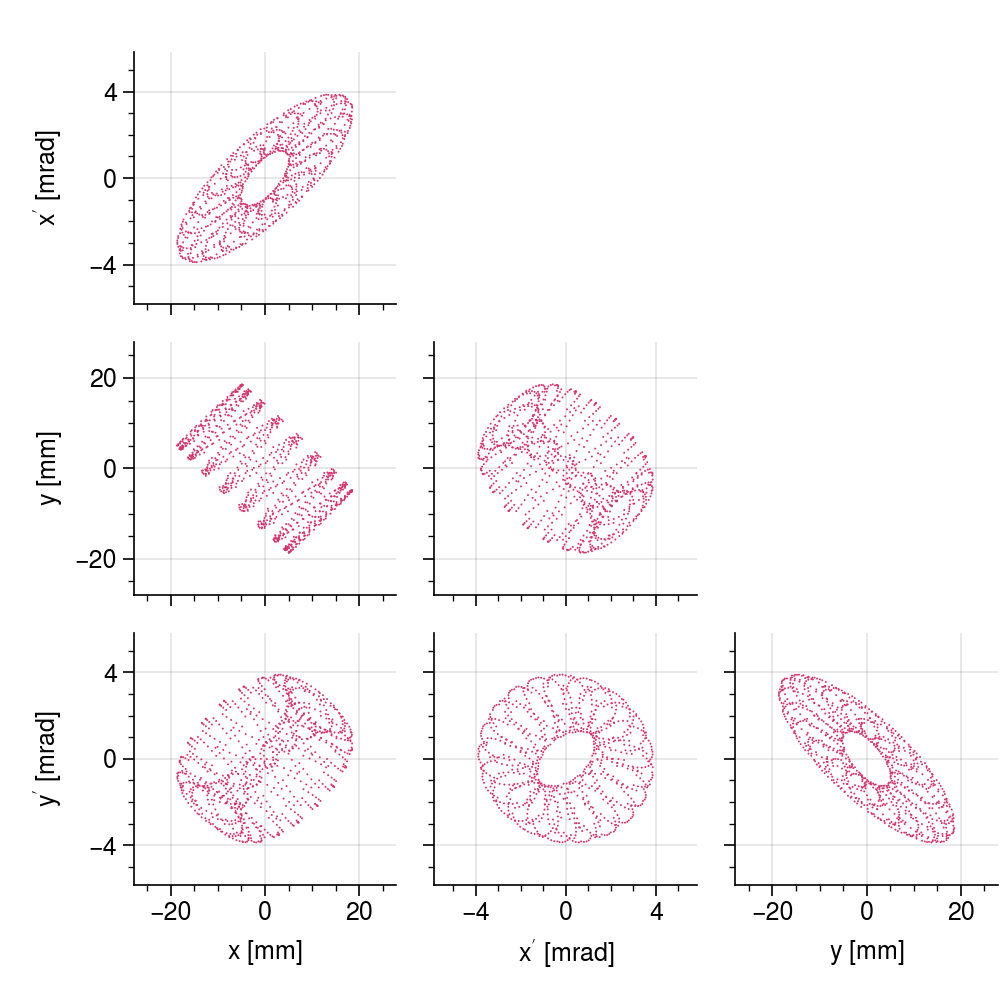

In [3]:
#hide
L = 5.0
k1, k2 = 0.25, 0.25
lattice = ml.fodo(k1, k2, L, fill_fac=0.5, quad_tilt=1, start='drift')

nturns = 1000
eps1 = 40 # [mm-mrad]
eps2 = 10 # [mm-mrad]
psi1 = 0 # initial phase of eigenvector 1
psi2 = np.radians(90) # initial phase of eigenvector 2

# Form coordinate vector
x1 = np.real(np.sqrt(eps1) * lattice.v1 * np.exp(1j*psi1)) # mode 1 contribution
x2 = np.real(np.sqrt(eps2) * lattice.v2 * np.exp(1j*psi2)) # mode 2 contribution
x = x1 + x2

# Track
X1 = lattice.track_part(x1, nturns)
X2 = lattice.track_part(x2, nturns)
X = lattice.track_part(x, nturns)

myplt.corner(X, diag_kind=None, alpha=1, s=2, c='pink7');

In [7]:
#hide_input
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['axes.grid'] = False
anim = myanim.corner_onepart(
    X[:75], 
    dims='all', 
    figsize=5, 
    show_history=True, 
    text_fmt='Period = {}',
    fps=7,
#     label_kws=dict(fontsize='small'),
#     tick_kws=dict(labelsize='small'),
    history_kws=dict(s=4, alpha=1, color='pink7'),
    color='black',
    s=8
)
anim

Remember: these are snapshots at a single position in the lattice. The particle traces interesting donut-like shapes in horizontal ($x$-$x'$) and vertical ($y$-$y'$) phase space instead of ellipses. Some cool designs can be created by changing the lattice parameters.

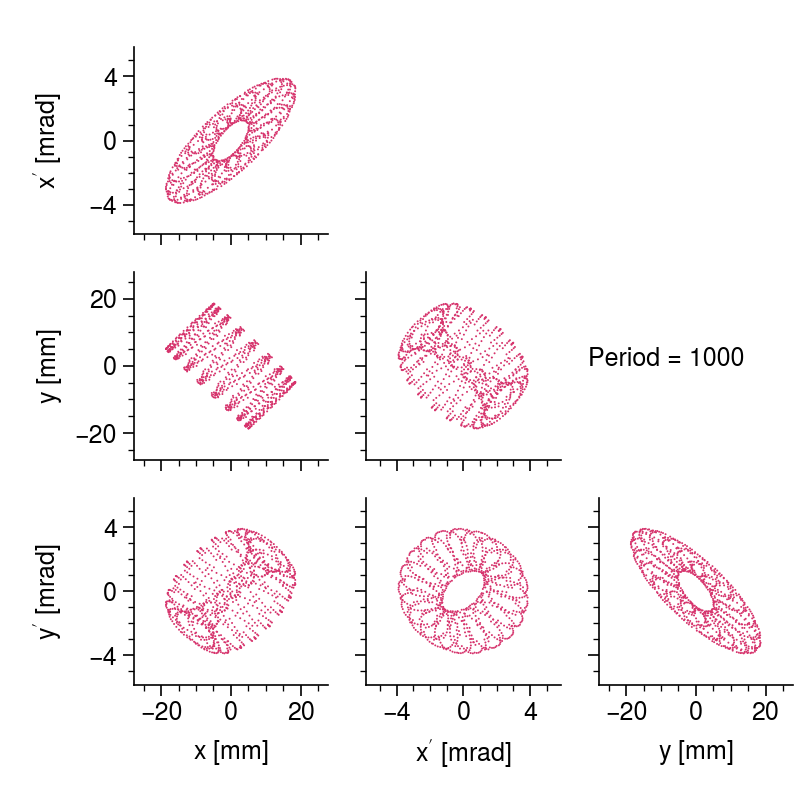

In [12]:
#hide_input
myplt.corner(X, diag_kind=None, figsize=4, alpha=1, s=2, c='pink7',
             text='Period = 1000');

There is definitely more than one frequency present, which we see if we plot the $x$ and $y$ position vs period number and take the FFT. 

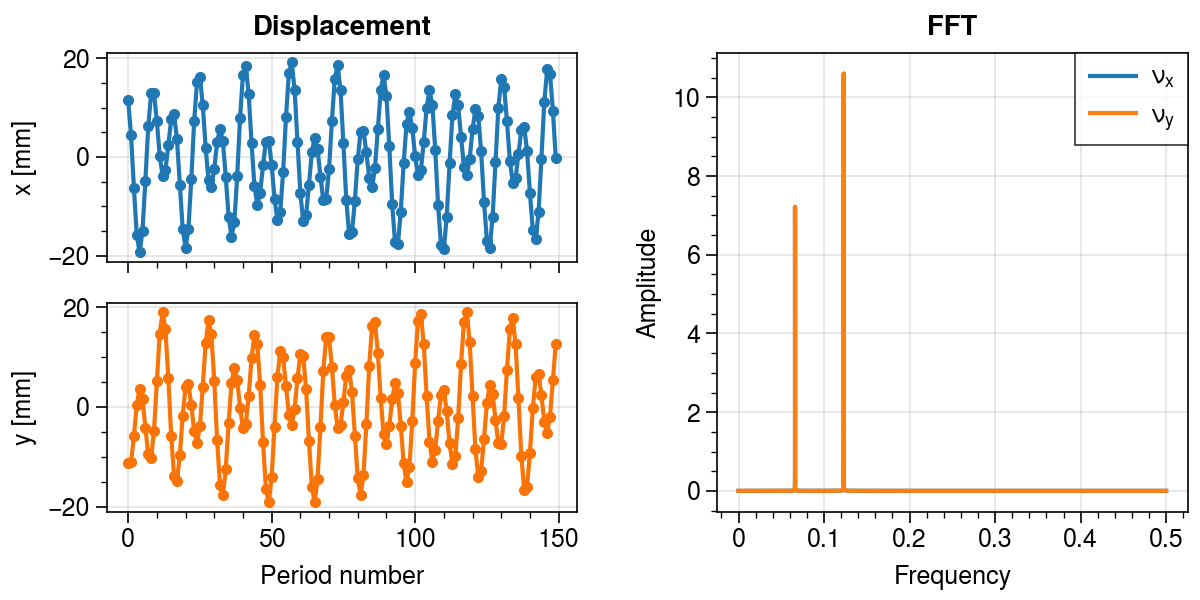

In [157]:
#hide_input

# TBT trajectory
fig, axes = plot.subplots([[1, 3], [2, 3]], figsize=(6, 3), span=False, wspace=[0.7])
x, y = X[:150, [0, 2]].T
axes[0].plot(x, marker='.')
axes[1].plot(y, marker='.', color='orange')
axes[0].format(ylabel='x [mm]')
axes[1].format(ylabel='y [mm]', xlabel='Period number')

# FFT
x, y = X[:, [0, 2]].T
N = len(x)
M = N // 2
f = (1/N) * np.arange(M)
xf = (1/M) * abs(scipy.fft.fft(x)[:M])
yf = (1/M) * abs(scipy.fft.fft(y)[:M])
axes.format(toplabels=['Displacement', 'FFT'])
axes[2].format(xlabel='Frequency', ylabel='Amplitude')
axes[2].plot(f[1:], xf[1:], label=r'$\nu_x$')
axes[2].plot(f[1:], yf[1:], label=r'$\nu_y$')
axes[2].legend(ncols=1);

This is typical of a coupled oscillator. Such systems are typically understood as the superposition of [normal modes](https://en.wikipedia.org/wiki/Normal_mode), each of which corresponds to a single frequency. For example, consider two masses connected with a spring. The system has a *breathing mode*, in which masses move in opposite directions, and a *sloshing mode*, in which the masses move in the same direction. The motion is simply the sum of these two modes. We will try to do something similar for a coupled parameteric oscillator.

## Transfer matrix

Our analysis will depend heavily on the eigenvectors the one-period transfer matrix. For $\mathbf{x} = (x, x', y, y')^T$ we have

$$\mathbf{x} \rightarrow \mathbf{Mx}.$$

It can be shown that $\mathbf{M}$ is [symplectic](https://en.wikipedia.org/wiki/Symplectic_matrix#Properties) due to the Hamiltonian mechanics of the system. We can solve for the eigenvectors from

$$\mathbf{Mv} = e^{-i\mu}\mathbf{v}.$$

Because $\mathbf{M}$ is symplectic, the eigenvalues and eigenvectors come in two complex conjugate pairs; this gives $\mathbf{v}_1$, $\mathbf{v}_2$, $\mu_1$, $\mu_2$ and their complex conjugates. Applying the transfer matrix to the eigenvectors simply causes them to rotate in the complex plane by an amount $\mu$.

### Physical meaning of eigenvectors 

The seemingly complex motion above is greatly simplified when written in terms of the eigenvectors. We can write any cooridinate vector as a linear combination of the real and imaginary components of $\mathbf{v}_1$ and $\mathbf{v}_2$:

$$\mathbf{x} = Re \left(\sqrt{\epsilon_1}\mathbf{v}_1e^{-i\psi_1} + \sqrt{\epsilon_2}\mathbf{v}_2e^{-i\psi_2}\right).$$

We've introduced two initial phases ($\epsilon_1$ and $\epsilon_2$) as well as two initial phases ($\psi_1$ and $\psi_2$). Again, the transfer matrix simply tacks on a phase.

$$\mathbf{Mx} = Re \left(\sqrt{\epsilon_1}\mathbf{v}_1e^{-i\left(\psi_1 + \mu_1\right)} + \sqrt{\epsilon_2}\mathbf{v}_2e^{-i(\psi_2 + \mu_2)}\right).$$

Let's replay the animation with the inclusion of these eigenvectors (red for $\mathbf{v}_1$, blue for $\mathbf{v}_2$.

In [165]:
#hide_input
anim = myanim.corner_onepart(
    X[:40], 
    vecs=[X1, X2],
    dims='all', 
    figsize=5, 
    show_history=False, 
    text_fmt='Period = {}',
    fps=5,
    label_kws=dict(fontsize='small'),
    tick_kws=dict(labelsize='small'),
    color='black',
    s=8
)
anim

That really simplifies things! Each eigenvector simply rotates at its frequency $\mu_l$. It also explains why the amplitude int the $x$-$x'$ and $y$-$y'$ planes trade back and forth: it is because the projections of the eigenvectors rotate at different frequencies, sometimes aligning and sometimes anti-aligning.

### Parameterization of eigenvectors

The transfer matrix, or equivalently eigenvectors, shown above have 16 elements. Only 10 of these are independent due to the fact that $\mathbf{M}$ is symplectic. This is opposed to the 1D case in which the transfer matrix has 4 elements, 3 independent. We need to choose these 10 independent parameters.

We already have two phases, so that leaves 8 parameters. One strategy is to assign two parameters to each ellipse traced in the horizontal and vertical phase space. So for the ellipse traced by $\mathbf{v}_1$ in the $x$-$x'$ plane, we have $\beta_{1x}$ and $\alpha_{1x}$, and then for the second eigenvector we have $\beta_{2x}$ and $\alpha_{2x}$. The same thing goes for the vertical dimension.

<img src="images/4dtwiss.png">

That's pretty much it. There are a few other parameters, two relating to the phase relationship between the $x$ and $y$ components of the eigenvectors (in the animation they are either $0$ or $\pi$) as well as the size of the ellipse traced in one plane relative to the size in the other plane. They are not really independent and can be written in terms of the other parameters. It seems unnecessary to cover these here.